In [3]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
from IPython.display import display, clear_output
import time

In [17]:
class CustomNetwork(nn.Module):
    def __init__(self, input_shape, num_classes, distance_threshold, max_neurons):
        super(CustomNetwork, self).__init__()
        self.distance_threshold = distance_threshold
        self.input_shape = input_shape
        
        # Initialize neurons tensor
        # Each row: [label, flattened memory tensor, update counter]
        self.neurons = torch.zeros((num_classes, 1 + input_shape[0] * input_shape[1] + 1))
        self.neurons[:, 0] = torch.arange(num_classes, dtype=torch.float32)  # Initialize the labels supposing it's [0, num_classes-1]
        self.neurons[:, -1] = 0  # Initialize counters to 0

        self.max_neurons = max_neurons  # Check it out depending on data set size and num classes
        self.current_neurons = self.neurons.shape[0]  # Initialize it to initial number of neurons

        # Initialize plot
        self.fig, self.axarr = plt.subplots(2, 5, figsize=(10, 4))
        self.images = []
        for i in range(2):
            for j in range(5):
                ax = self.axarr[i, j]
                img = ax.imshow(torch.zeros(self.input_shape), cmap='gray', vmin=0, vmax=255)
                ax.set_title('Unused')
                ax.axis('off')
                self.images.append(img)
        plt.ion()
        plt.show()

    def forward(self, x):
        pass

    def train_network(self, dataloader):
        for i, (input_tensor, label) in enumerate(dataloader):
            input_tensor = input_tensor.view(-1)  # Flatten the input tensor
            label = label.item()  # Assuming label is a single element tensor

            ############
            label_mask = self.neurons[:, 0] == label
            label_indices = torch.nonzero(label_mask)

            distances = torch.norm(self.neurons[label_mask][:, 1:-1] - input_tensor, dim=1)  # This is the distances for all neurons with the same label
            closest_distance_mask = distances == torch.min(distances)
            
            # If the closest_distance_mask isn't empty or if the max number of neurons has been reached
            if (distances[closest_distance_mask] > self.distance_threshold) or not(self.current_neurons < self.max_neurons):
                # Debugging
                #if (distances[closest_distance_mask] > self.distance_threshold):
                    #print('Add into existing neuron')

                #if not(self.current_neurons < self.max_neurons):
                    #print('Add into the closest neuron because memory full')
                    
                closest_distance_index = label_indices[closest_distance_mask]

                self.neurons[closest_distance_index, -1] += 1  # Update counter

                weight = 1 / self.neurons[closest_distance_index, -1]
                self.neurons[closest_distance_index, 1:-1] = (
                    self.neurons[closest_distance_index, 1:-1] * (1 - weight) + input_tensor * weight
                )
            # If self.current_neurons < self.max_neurons // memory isn't full
            else:
                #print('Add into a new neuron')
                new_neuron = torch.zeros((1, 1 + self.input_shape[0] * self.input_shape[1] + 1))
                new_neuron[0, 0] = label
                new_neuron[0, 1:-1] = input_tensor
                new_neuron[0, -1] = 1  # Counter initialized to 1

                # Add the new neuron to the neurons tensor
                self.neurons = torch.cat((self.neurons, new_neuron), dim=0)
                self.current_neurons += 1

            ############
            #print(f"Updating plot at step {i}")  # Debugging
            self.update_plot()

        plt.ioff()
        plt.show()

    def update_plot(self):
        #print("Inside update_plot")  # Debugging
        for idx in range(10):
            neuron_image = self.neurons[idx, 1:-1].view(self.input_shape).detach().numpy()
            counter = int(self.neurons[idx, -1].item())
            #print(f"Neuron {idx} image data (min, max): {neuron_image.min()}, {neuron_image.max()}")  # Debugging
            self.images[idx].set_data(neuron_image)
            self.axarr[idx // 5, idx % 5].set_title(f'Count: {counter}')
        
        clear_output(wait=True)
        display(self.fig)
        time.sleep(0.1)  # Small pause to allow the plot to update

    def predict(self, input_tensor):
        input_tensor = input_tensor.view(-1)  # Flatten the input tensor
        
        distances = torch.norm(self.neurons[:, 1:-1] - input_tensor, dim=1)  # This is the distances for all neurons with the same label
        closest_distance_mask = distances == torch.min(distances)
        predicted_label = self.neurons[closest_distance_mask, 0].item()  # Get the label of the closest neuron
        
        return predicted_label

    def get_neuron_tensors(self): 
        return self.neurons


In [18]:
# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x * 255)])
mnist_train = datasets.MNIST(root='.', train=True, download=True, transform=transform)

# Create DataLoader
dataloader = DataLoader(mnist_train, batch_size=1, shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



51.2%IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

78.9%IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

100.0%


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



102.8%


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



112.7%

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

Processing...
Done!



/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


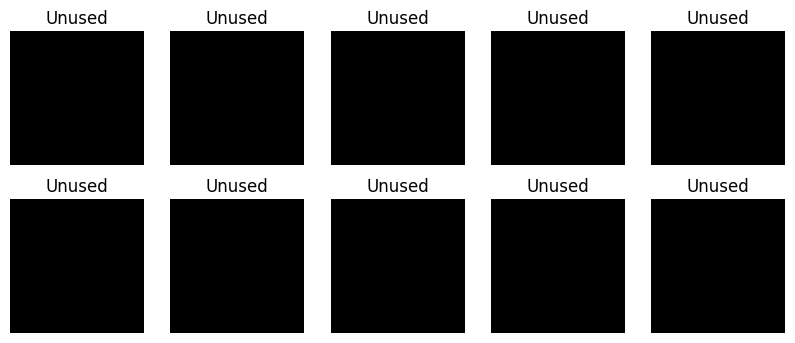

In [19]:
input_shape = (28, 28)  # Example input shape (e.g., 28x28 images)
num_classes = 10
distance_threshold = 0
max_neurons = 100

network = CustomNetwork(input_shape, num_classes, distance_threshold, max_neurons)

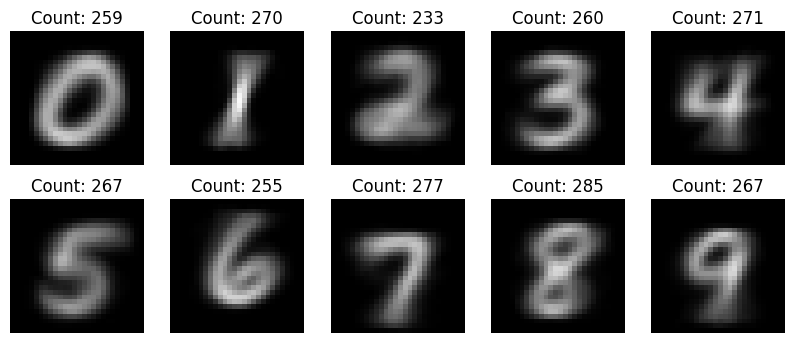

KeyboardInterrupt: 

In [20]:
# Train the network
network.train_network(dataloader)

In [220]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

class CustomNetwork(nn.Module):
    def __init__(self, input_shape, num_classes, distance_threshold, max_neurons):
        super(CustomNetwork, self).__init__()
        self.distance_threshold = distance_threshold
        self.input_shape = input_shape
        self.max_neurons = max_neurons
        
        # Initialize neurons tensor
        # Each row: [label, flattened memory tensor, update counter]
        self.neurons = torch.zeros((max_neurons, 1 + input_shape[0] * input_shape[1] + 1))
        self.neurons[:, 0] = -1 # uninitalized labels
        self.neurons[:num_classes, 0] = torch.arange(num_classes, dtype=torch.float32) # initialize the labels supposing its [0,numclass-1]
        self.neurons[:, -1] = 0  # Initialize counters to 0

        self.current_neurons = num_classes # initial occupied neurons , 10.

    def forward(self, x):
        pass

    def train_network(self, dataloader):

        for i, (input_tensor, label) in enumerate(dataloader):
            if i>101:
                break
            input_tensor = input_tensor.view(-1)  # Flatten the input tensor
            label = label.item()  # Assuming label is a single element tensor

            ############
            label_mask = self.neurons[:, 0] == label
            label_indices = torch.nonzero(label_mask)
            #print(input_tensor.shape,  self.neurons.shape, self.neurons[label_mask][:, 1:-1].shape)
            #torch.Size([784]) torch.Size([1000, 786]) torch.Size([1, 784])

            #dists = torch.sum((test_data.reshape(10000, -1).unsqueeze(1) - class_means.reshape(10,-1)) ** 2, dim=(2))
            distances = torch.norm(input_tensor - self.neurons[label_mask][:, 1:-1] , dim=1) # this is the distances for all n w same label
            closest_distance_mask = distances == torch.min(distances)

            # if the closest_distance_mask isn't empty or if the max number of neurons has been reached
            if (distances[closest_distance_mask] < self.distance_threshold) or not(self.current_neurons < self.max_neurons) or i<100 :
                # debugging
                if (distances[closest_distance_mask] < self.distance_threshold):
                    print('add into existing neuron',distances[closest_distance_mask] )
        
                if not(self.current_neurons < self.max_neurons):
                    print('add into the closest neuron because memory full ')
                    
                closest_distance_index = label_indices[closest_distance_mask]
                
    
                self.neurons[closest_distance_index, -1] += 1 # update counter

                weight = 1/self.neurons[closest_distance_index, -1] #get counter for update
                self.neurons[closest_distance_index, 1:-1] += input_tensor.unsqueeze(0) * weight # here you would do the average operation
    
            # if self.current_neurons < self.max_neurons //// memory isn't full
            else:
                print('add into a new neuron')
                #find empty neurons and get in the first one: 
                print(distances)
                masko = self.neurons[:, 0] == -1

                label_indices = torch.arange(self.neurons.shape[0], dtype=torch.float32)

                first_index = int(label_indices[masko][0].item())

                self.neurons[first_index, 0] = label
                self.neurons[first_index, 1:-1] = input_tensor
                self.neurons[first_index, -1] = 1
                # if none found this is a omega bug
                
                # Add the new neuron to the neurons tensor
                self.current_neurons += 1
            
    def predict(self, input_tensor):
        
        input_tensor = input_tensor.view(-1)  # Flatten the input tensor
        
        distances = torch.norm(self.neurons[:, 1:-1] - input_tensor, dim=1) # this is the distances for all n w same label
        closest_distance_mask = distances == torch.min(distances)
        # test this shape
        predicted_label = self.neurons[closest_distance_mask]
        
        return predicted_label

    def get_neuron_tensors(self): 
        return self.neurons

In [221]:
# Example usage
input_shape = (28, 28)  # Example input shape (e.g., 28x28 images)
num_classes = 10
distance_threshold = 10
max_neurons = 50

networkTestAdd = CustomNetwork(input_shape, num_classes, distance_threshold, max_neurons)

In [222]:
networkTestAdd.train_network(dataloader)

add into a new neuron
tensor([3590.4255])
add into a new neuron
tensor([3680.1611])


In [210]:
p = networkTestAdd.get_neuron_tensors()

In [211]:
p[:,0]

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.,  7.,  3., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1.])

In [34]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


In [112]:

# Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [28]:
# Function to compute distances
def compute_distances(images1, images2):
    return torch.norm(images1 - images2)

# Step 2: Compute distances between pairs of images within the same class and between different classes
def compute_class_distances(dataset):
    class_images = {i: [] for i in range(10)}
    for image, label in dataset:
        class_images[label].append(image.squeeze())

    class_distances = {i: [] for i in range(10)}
    for label, images in class_images.items():
        images = torch.stack(images)
        for i in range(len(images)):
            for j in range(i + 1, len(images)):
                distance = compute_distances(images[i], images[j])
                class_distances[label].append(distance.item())

    return class_distances

train_class_distances = compute_class_distances(train_dataset)
test_class_distances = compute_class_distances(test_dataset)

# Step 3: Calculate the average image for each class
def calculate_average_images(dataset):
    class_images = {i: [] for i in range(10)}
    for image, label in dataset:
        class_images[label].append(image.squeeze())

    average_images = {}
    for label, images in class_images.items():
        images = torch.stack(images)
        average_images[label] = images.mean(dim=0)

    return average_images

train_average_images = calculate_average_images(train_dataset)
test_average_images = calculate_average_images(test_dataset)

# Step 4: Compute the distance between each image of a class and the averaged sum image of the same class
def compute_distances_to_average(dataset, average_images):
    distances_to_average = {i: [] for i in range(10)}
    for image, label in dataset:
        image = image.squeeze()
        average_image = average_images[label]
        distance = torch.norm(image - average_image)
        distances_to_average[label].append(distance.item())

    return distances_to_average

train_distances_to_average = compute_distances_to_average(train_dataset, train_average_images)
test_distances_to_average = compute_distances_to_average(test_dataset, test_average_images)

# Step 5: Evaluate the distance metric as a classifier (example code for visualization/printing purposes)
def print_distances(distances):
    for label, dists in distances.items():
        print(f"Class {label}: {len(dists)} distances, Mean Distance: {sum(dists)/len(dists):.4f}")

print("Train distances within the same class:")
print_distances(train_class_distances)
print("\nTest distances within the same class:")
print_distances(test_class_distances)

print("\nTrain distances to average images:")
print_distances(train_distances_to_average)
print("\nTest distances to average images:")
print_distances(test_distances_to_average)

# Additional evaluation can be done here by thresholding the distances and checking the accuracy of classification

Train distances within the same class:
Class 0: 17538003 distances, Mean Distance: 9.8665
Class 1: 22723911 distances, Mean Distance: 6.4642
Class 2: 17745903 distances, Mean Distance: 9.9986
Class 3: 18791515 distances, Mean Distance: 9.3836
Class 4: 17061561 distances, Mean Distance: 8.9453
Class 5: 14690910 distances, Mean Distance: 9.6493
Class 6: 17508403 distances, Mean Distance: 9.1536
Class 7: 19621980 distances, Mean Distance: 8.5268
Class 8: 17114175 distances, Mean Distance: 9.4544
Class 9: 17692326 distances, Mean Distance: 8.6528

Test distances within the same class:
Class 0: 479710 distances, Mean Distance: 9.7972
Class 1: 643545 distances, Mean Distance: 6.4287
Class 2: 531996 distances, Mean Distance: 9.9184
Class 3: 509545 distances, Mean Distance: 9.2383
Class 4: 481671 distances, Mean Distance: 8.9136
Class 5: 397386 distances, Mean Distance: 9.6348
Class 6: 458403 distances, Mean Distance: 9.2633
Class 7: 527878 distances, Mean Distance: 8.4470
Class 8: 473851 dist

Example to visualize the Mean distance between eleemnts of different classes.

In [36]:
# Extract the data and labels for classes of interest from the training set
def extract_classes(loader, classes):
    data = []
    labels = []
    for images, targets in loader:
        for i in range(len(targets)):
            if targets[i].item() in classes:
                data.append(images[i].view(-1).numpy())
                labels.append(targets[i].item())
    return np.array(data), np.array(labels)

# Extract classes 0, 1, 4, and 7
train_data, train_labels = extract_classes(train_loader, [0, 1, 4, 7])
test_data, test_labels = extract_classes(test_loader, [0, 1, 4, 7])

# Define the function to compute average distances
def compute_average_distances(X, y):
    # Get indices of each class
    class_0_idx = np.where(y == 0)[0]
    class_4_idx = np.where(y == 4)[0]
    class_1_idx = np.where(y == 1)[0]
    class_7_idx = np.where(y == 7)[0]
    
    # Compute distances between elements of class 0 and class 4
    dist_0_4 = []
    for i in class_0_idx:
        for j in class_4_idx:
            dist_0_4.append(np.linalg.norm(X[i] - X[j]))
    avg_dist_0_4 = np.mean(dist_0_4)
    
    # Compute centroid of class 0 and class 4
    centroid_0 = np.mean(X[class_0_idx], axis=0)
    centroid_4 = np.mean(X[class_4_idx], axis=0)
    
    # Compute distances between centroid of class 0 and elements of class 4
    dist_centroid_0_class_4 = [np.linalg.norm(centroid_0 - X[j]) for j in class_4_idx]
    avg_dist_centroid_0_class_4 = np.mean(dist_centroid_0_class_4)
    
    # Compute distances between centroid of class 4 and elements of class 0
    dist_centroid_4_class_0 = [np.linalg.norm(centroid_4 - X[i]) for i in class_0_idx]
    avg_dist_centroid_4_class_0 = np.mean(dist_centroid_4_class_0)
    
    # Compute distances between elements of class 1 and class 7
    dist_1_7 = []
    for i in class_1_idx:
        for j in class_7_idx:
            dist_1_7.append(np.linalg.norm(X[i] - X[j]))
    avg_dist_1_7 = np.mean(dist_1_7)
    
    # Compute centroid of class 1 and class 7
    centroid_1 = np.mean(X[class_1_idx], axis=0)
    centroid_7 = np.mean(X[class_7_idx], axis=0)
    
    # Compute distances between centroid of class 1 and elements of class 7
    dist_centroid_1_class_7 = [np.linalg.norm(centroid_1 - X[j]) for j in class_7_idx]
    avg_dist_centroid_1_class_7 = np.mean(dist_centroid_1_class_7)
    
    # Compute distances between centroid of class 7 and elements of class 1
    dist_centroid_7_class_1 = [np.linalg.norm(centroid_7 - X[i]) for i in class_1_idx]
    avg_dist_centroid_7_class_1 = np.mean(dist_centroid_7_class_1)
    
    results = {
        'avg_dist_0_4': avg_dist_0_4,
        'avg_dist_centroid_0_class_4': avg_dist_centroid_0_class_4,
        'avg_dist_centroid_4_class_0': avg_dist_centroid_4_class_0,
        'avg_dist_1_7': avg_dist_1_7,
        'avg_dist_centroid_1_class_7': avg_dist_centroid_1_class_7,
        'avg_dist_centroid_7_class_1': avg_dist_centroid_7_class_1
    }
    
    return results

# Compute average distances for the training data
train_results = compute_average_distances(train_data, train_labels)
print("Training set results:", train_results)

# Compute average distances for the test data
test_results = compute_average_distances(test_data, test_labels)
print("Test set results:", test_results)

Training set results: {'avg_dist_0_4': 11.336939, 'avg_dist_centroid_0_class_4': 8.923415, 'avg_dist_centroid_4_class_0': 9.365321, 'avg_dist_1_7': 9.3368, 'avg_dist_centroid_1_class_7': 8.046497, 'avg_dist_centroid_7_class_1': 7.138963}
Test set results: {'avg_dist_0_4': 11.3485365, 'avg_dist_centroid_0_class_4': 8.980538, 'avg_dist_centroid_4_class_0': 9.394868, 'avg_dist_1_7': 9.301026, 'avg_dist_centroid_1_class_7': 8.019415, 'avg_dist_centroid_7_class_1': 7.1383467}


In [37]:
# Define a function to print the results in a readable format
def print_results(results, dataset_type):
    print(f"\n{dataset_type} set results:")
    print(f"Average distance between class 0 and class 4: {results['avg_dist_0_4']:.4f}")
    print(f"Average distance between centroid of class 0 and elements of class 4: {results['avg_dist_centroid_0_class_4']:.4f}")
    print(f"Average distance between centroid of class 4 and elements of class 0: {results['avg_dist_centroid_4_class_0']:.4f}")
    print(f"Average distance between class 1 and class 7: {results['avg_dist_1_7']:.4f}")
    print(f"Average distance between centroid of class 1 and elements of class 7: {results['avg_dist_centroid_1_class_7']:.4f}")
    print(f"Average distance between centroid of class 7 and elements of class 1: {results['avg_dist_centroid_7_class_1']:.4f}")

# Compute average distances for the training data
print_results(train_results, "Training")

# Compute average distances for the test data
print_results(test_results, "Test")


Training set results:
Average distance between class 0 and class 4: 11.3369
Average distance between centroid of class 0 and elements of class 4: 8.9234
Average distance between centroid of class 4 and elements of class 0: 9.3653
Average distance between class 1 and class 7: 9.3368
Average distance between centroid of class 1 and elements of class 7: 8.0465
Average distance between centroid of class 7 and elements of class 1: 7.1390

Test set results:
Average distance between class 0 and class 4: 11.3485
Average distance between centroid of class 0 and elements of class 4: 8.9805
Average distance between centroid of class 4 and elements of class 0: 9.3949
Average distance between class 1 and class 7: 9.3010
Average distance between centroid of class 1 and elements of class 7: 8.0194
Average distance between centroid of class 7 and elements of class 1: 7.1383


In [38]:
# do the accuracy for the full experiment on 10 neurons and then increase if possible.

# Training the 10 neuron network = computing mean per class on training set

In [4]:
# training one shot = parallel
# testing in sequence distance computation

In [6]:
device = torch.device('cuda:7' if torch.cuda.is_available() else 'cpu')

In [7]:
import torch
from torchvision import datasets, transforms

# Define the transformation
transform = transforms.Compose([transforms.ToTensor()])

# Load the MNIST training dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Load the MNIST test dataset
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Convert the datasets to single tensors
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=len(train_dataset))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset))

train_data, train_labels = next(iter(train_loader))
test_data, test_labels = next(iter(test_loader))

# Move data to GPU
train_data, train_labels = train_data.to(device), train_labels.to(device)
test_data, test_labels = test_data.to(device), test_labels.to(device)

In [8]:
train_data.shape, train_labels.shape

(torch.Size([60000, 1, 28, 28]), torch.Size([60000]))

In [9]:
test_data.shape, test_labels.shape

(torch.Size([10000, 1, 28, 28]), torch.Size([10000]))

In [10]:
# Initialize accumulators
num_classes = 10
image_shape = train_data.shape[2:]  # Shape of MNIST images
class_sums = torch.zeros((num_classes, *image_shape), dtype=torch.float32, device=device)
class_counts = torch.zeros(num_classes, dtype=torch.float32, device=device)

# Compute the sums and counts per class
for i in range(num_classes):
    class_mask = (train_labels == i).unsqueeze(1).unsqueeze(2).unsqueeze(3)
    class_images = train_data * class_mask.float()
    class_sums[i] = class_images.sum(dim=0)
    class_counts[i] = class_mask.float().sum()

# Compute the mean per pixel per class
class_means = class_sums / class_counts.view(-1, 1, 1)

print(class_means.shape)  # Should be (10, 28, 28)

torch.Size([10, 28, 28])


In [11]:
print(torch.sum(class_counts))
class_counts

tensor(60000., device='cuda:7')


tensor([5923., 6742., 5958., 6131., 5842., 5421., 5918., 6265., 5851., 5949.],
       device='cuda:7')

In [12]:
class_means_cpu = class_means.cpu()

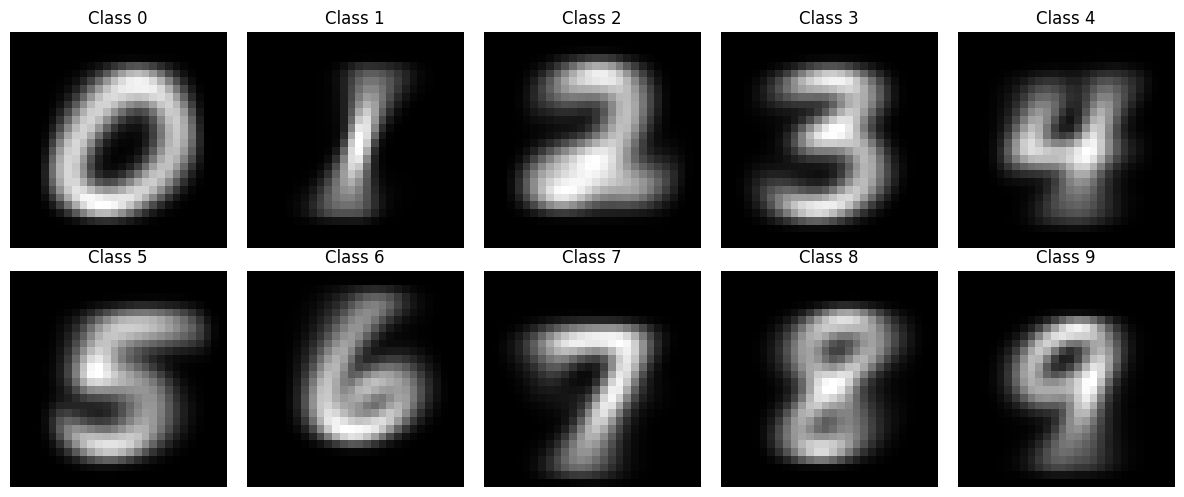

In [13]:
import matplotlib.pyplot as plt

# Set up the figure and axes
fig, axes = plt.subplots(2, 5, figsize=(12, 5))

# Plot each mean image
for i, ax in enumerate(axes.flat):
    ax.imshow(class_means_cpu[i].squeeze(), cmap='gray')
    ax.set_title(f'Class {i}')
    ax.axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

In [14]:
test_data.shape

torch.Size([10000, 1, 28, 28])

In [15]:
device

device(type='cuda', index=7)

In [16]:
# Reshape class_means to match the test_data dimensions for broadcasting
class_means = class_means.view(num_classes, 1, *image_shape)  # Reshape: (10, 1, 28, 28)

# Compute the L2 distance between each test image and each class mean
# Using broadcasting to compute (10, N, 28, 28) - (N, 28, 28) => (10, N, 28, 28)
dists = torch.sum((test_data.unsqueeze(1) - class_means) ** 2, dim=(2, 3))  # Shape: (10, N)
dists = torch.sqrt(dists)

In [17]:
pe = test_data.reshape(10000, -1).unsqueeze(1)
pe.shape

torch.Size([10000, 1, 784])

In [18]:
dists = torch.sum((test_data.reshape(10000, -1).unsqueeze(1) - class_means.reshape(10,-1)) ** 2, dim=(2))  # Shape: (10, N)

In [19]:
dists.shape

torch.Size([10000, 10])

In [20]:
# Reshape class_means to match the test_data dimensions for broadcasting
class_means = class_means.view(num_classes, 1, *image_shape)  # Reshape: (10, 1, 28, 28)

# Compute the L2 distance between each test image and each class mean
# Using broadcasting to compute (10, N, 28, 28) - (N, 28, 28) => (10, N, 28, 28)
dists = torch.sum((test_data.reshape(test_data.shape[0], -1).unsqueeze(1) - class_means.reshape(class_means.shape[0],-1)) ** 2, dim=(2))

# Choose the class with the smallest distance
pred_labels = torch.argmin(dists, dim=1)  # Shape: (N,)
print(pred_labels.shape)

# Compute the accuracy
accuracy = torch.mean((pred_labels == test_labels).float())

print(f'Accuracy: {accuracy.item() * 100:.2f}%')

torch.Size([10000])
Accuracy: 82.03%


In [26]:
import torch
import matplotlib.pyplot as plt

# Reshape class_means to match the test_data dimensions for broadcasting
class_means = class_means.view(num_classes, 1, *image_shape)  # Reshape: (10, 1, 28, 28)

# Compute the L2 distance between each test image and each class mean
# Using broadcasting to compute (10, N, 28, 28) - (N, 28, 28) => (10, N, 28, 28)
dists = torch.sum((test_data.reshape(test_data.shape[0], -1).unsqueeze(1) - class_means.reshape(class_means.shape[0], -1)) ** 2, dim=2)
dists = torch.sqrt(dists)

# Choose the class with the smallest distance
pred_labels = torch.argmin(dists, dim=1)  # Shape: (N,)
print(pred_labels.shape)

# Compute the accuracy
accuracy = torch.mean((pred_labels == test_labels).float())
print(f'Accuracy: {accuracy.item() * 100:.2f}%')

# Identify misclassified images
misclassified_indices = (pred_labels != test_labels).nonzero(as_tuple=False).squeeze()

# Get distances of misclassified images
misclassified_dists = dists[misclassified_indices]

# Find the largest distances for the misclassified images
max_dists = torch.max(misclassified_dists, dim=1).values

# Sort misclassified images by their maximum distance
sorted_indices = torch.argsort(max_dists, descending=True)

# Select the top 10 worst classified images based on distance
top_10_indices = misclassified_indices[sorted_indices[:10]]

torch.Size([10000])
Accuracy: 82.03%


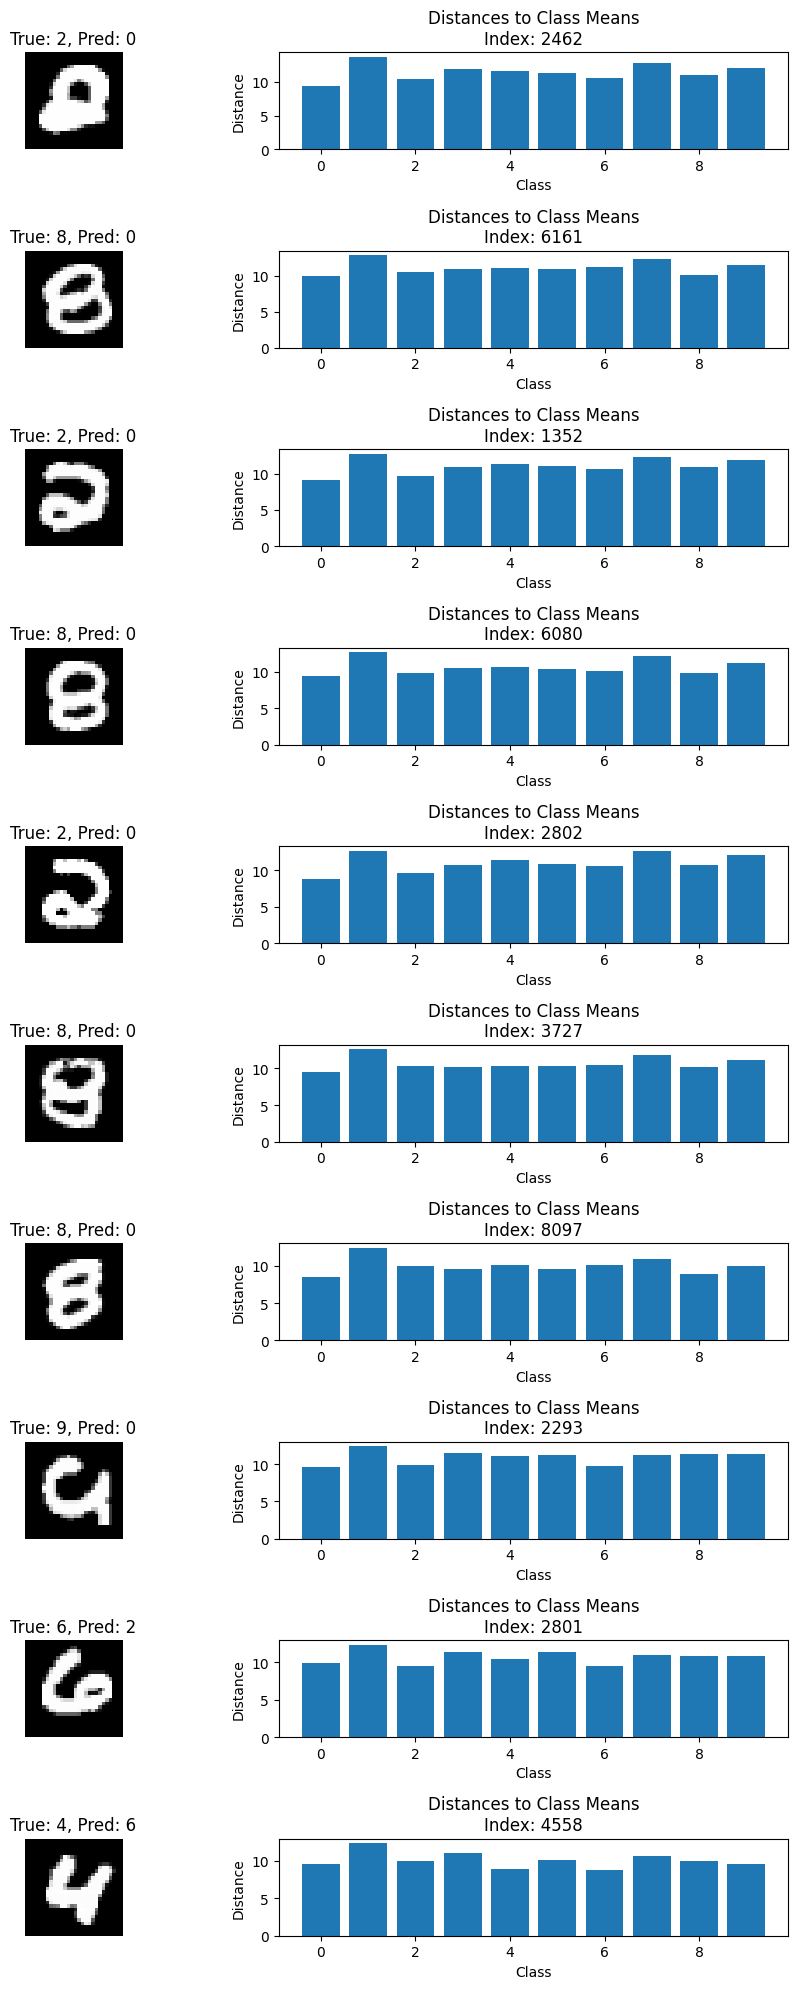

In [27]:
# Function to visualize images
def visualize_misclassified_images(test_data, test_labels, pred_labels, dists, indices, class_means):
    num_examples = len(indices)
    fig, axes = plt.subplots(num_examples, 2, figsize=(10, num_examples * 2))

    for i, idx in enumerate(indices):
        # Get the original image
        img = test_data[idx].cpu().numpy().reshape(28, 28)

        # Get the true and predicted labels
        true_label = test_labels[idx].item()
        pred_label = pred_labels[idx].item()

        # Get the distances to all class means
        dist_to_means = dists[idx].cpu().numpy()

        # Plot the misclassified image
        axes[i, 0].imshow(img, cmap='gray')
        axes[i, 0].set_title(f'True: {true_label}, Pred: {pred_label}')
        axes[i, 0].axis('off')

        # Plot the distances to all class means
        axes[i, 1].bar(range(num_classes), dist_to_means)
        axes[i, 1].set_title(f'Distances to Class Means\nIndex: {idx}')
        axes[i, 1].set_xlabel('Class')
        axes[i, 1].set_ylabel('Distance')

    plt.tight_layout()
    plt.show()

# Visualize the top 10 worst classified images
visualize_misclassified_images(test_data, test_labels, pred_labels, dists, top_10_indices, class_means)

## Plotting the distribution of distances for the full training set centroids

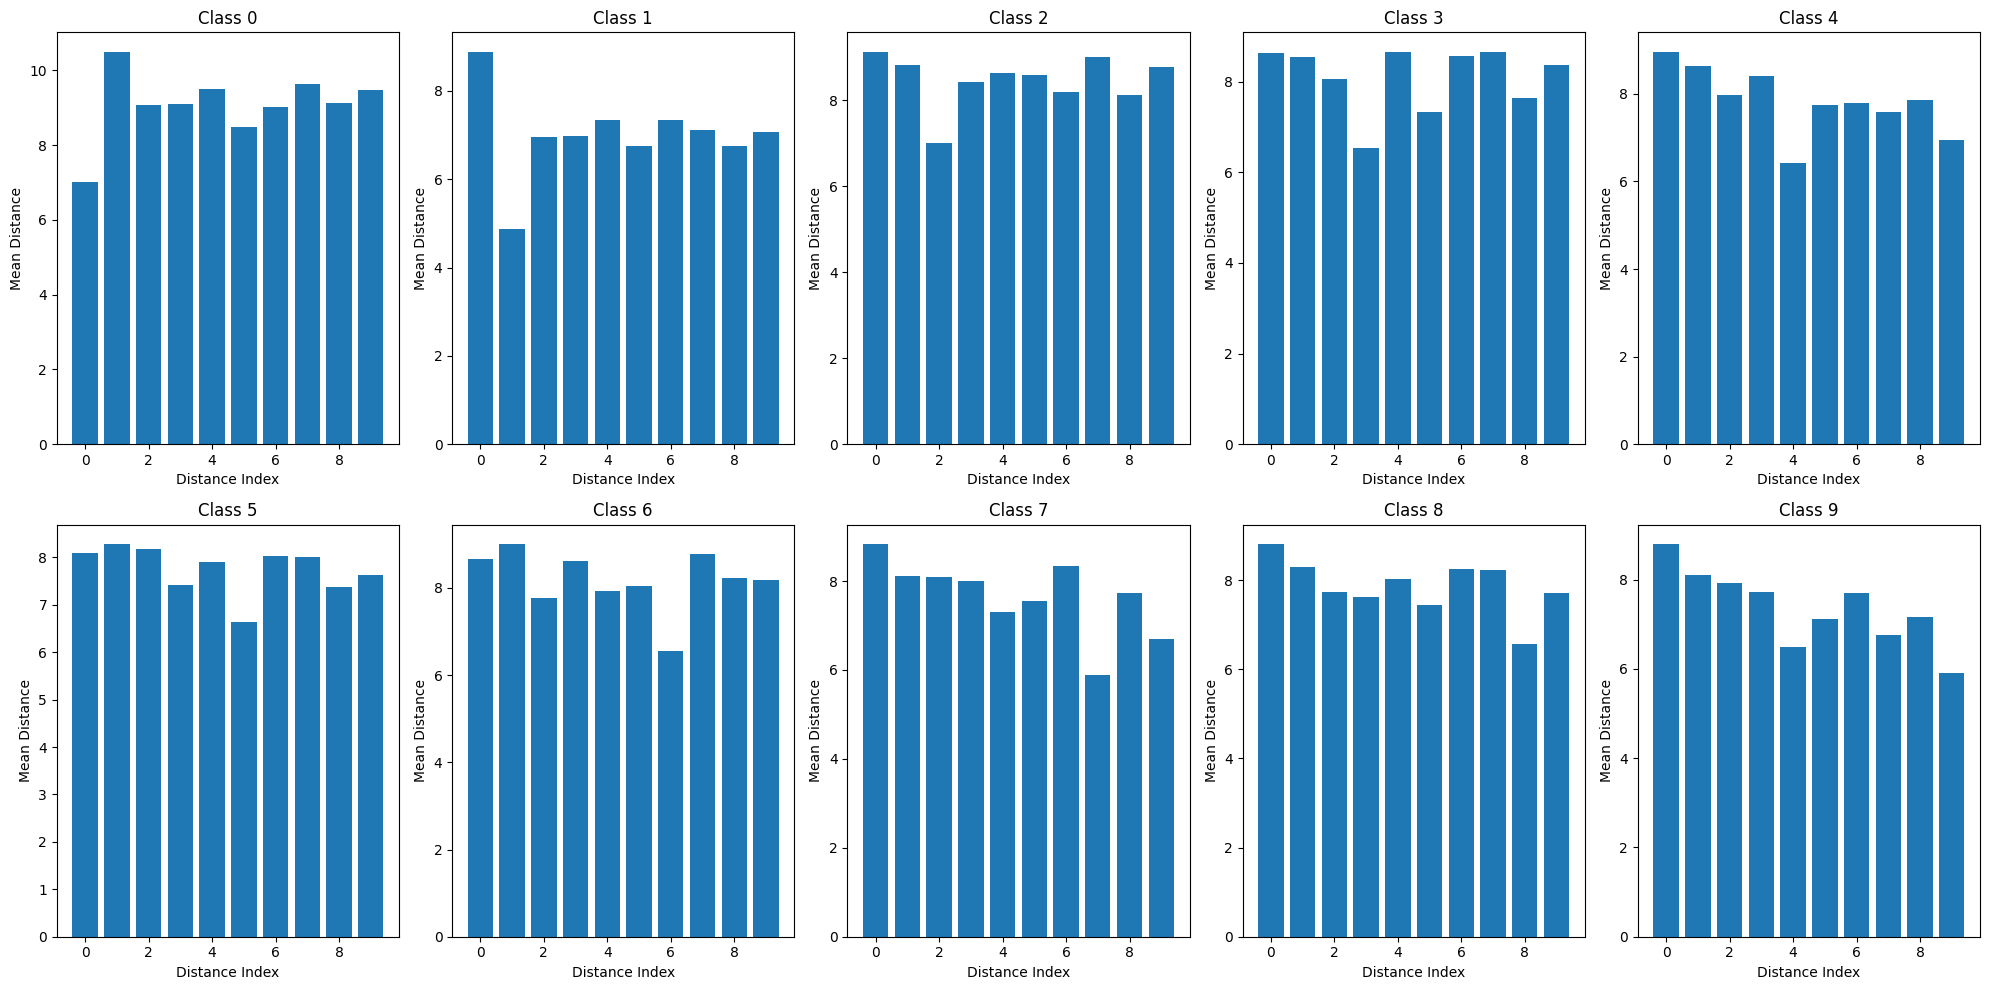

In [28]:
import torch
import matplotlib.pyplot as plt

# Assume dists is already a torch tensor of shape (10000, 10) on GPU
# Assume pred_labels is already a torch tensor of shape (10000) on GPU

# Move tensors to GPU if not already there
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dists = dists.to(device)
pred_labels = pred_labels.to(device)

# Prepare to store results
mean_distances = torch.zeros((10, 10), device=device)  # 10 classes, 10 distances

# Calculate mean distances for each class
for class_idx in range(10):
    class_mask = (pred_labels == class_idx)  # Mask for current class
    class_dists = dists[class_mask]  # Distances for current class
    mean_distances[class_idx] = class_dists.mean(dim=0)  # Mean of distances

# Move results to CPU for plotting
mean_distances = mean_distances.cpu()

# Plot histograms
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
axes = axes.ravel()

for class_idx in range(10):
    axes[class_idx].bar(range(10), mean_distances[class_idx].numpy())
    axes[class_idx].set_title(f'Class {class_idx}')
    axes[class_idx].set_xlabel('Distance Index')
    axes[class_idx].set_ylabel('Mean Distance')

plt.tight_layout()
plt.show()

In [29]:
torch.diag(mean_distances)

tensor([7.0076, 4.8702, 7.0092, 6.5455, 6.4295, 6.6409, 6.5635, 5.8766, 6.5613,
        5.9182])

In [30]:
mean_distances

tensor([[ 7.0076, 10.4933,  9.0784,  9.1080,  9.4954,  8.4942,  9.0264,  9.6249,
          9.1285,  9.4881],
        [ 8.8807,  4.8702,  6.9492,  6.9886,  7.3315,  6.7460,  7.3491,  7.1067,
          6.7403,  7.0659],
        [ 9.1239,  8.8310,  7.0092,  8.4178,  8.6381,  8.5781,  8.2010,  9.0157,
          8.1174,  8.7721],
        [ 8.6314,  8.5472,  8.0690,  6.5455,  8.6551,  7.3363,  8.5576,  8.6483,
          7.6497,  8.3739],
        [ 8.9558,  8.6303,  7.9717,  8.3975,  6.4295,  7.7520,  7.7925,  7.5863,
          7.8599,  6.9471],
        [ 8.0953,  8.2722,  8.1658,  7.4080,  7.8964,  6.6409,  8.0223,  8.0099,
          7.3648,  7.6365],
        [ 8.6717,  8.9978,  7.7801,  8.6262,  7.9317,  8.0361,  6.5635,  8.7875,
          8.2177,  8.1863],
        [ 8.8230,  8.1211,  8.1021,  8.0110,  7.2989,  7.5477,  8.3475,  5.8766,
          7.7218,  6.6930],
        [ 8.7984,  8.2841,  7.7253,  7.6191,  8.0296,  7.4369,  8.2543,  8.2358,
          6.5613,  7.6997],
        [ 8.7873,  

In [31]:
dists[0]

tensor([8.5123, 7.8691, 7.8490, 7.7189, 7.0058, 7.2662, 8.2235, 4.7894, 7.6921,
        6.4168], device='cuda:0')

In [19]:
pred_labels

tensor([7, 2, 1,  ..., 4, 5, 6], device='cuda:0')